In [1]:
import os
import pandas as pd
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from scipy.ndimage import zoom
from tqdm import tqdm
import itk
import SimpleITK as sitk
from typing import List
import psutil
import time
# from em_algorithm import em_algorithm
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

## Utility Functions

In [2]:
def readNiftiImage(file_path):
        # Read Nifti image
        try:
            niftiImage = nib.load(file_path).get_fdata()
            return niftiImage, nib.load(file_path).affine
        except Exception as e:
            print(f"Error reading NIFTI image from {file_path}: {str(e)}")           


def get_file_paths(folder_path):
    file_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".nii.gz"):
                file_paths.append(os.path.join(root, file))
    return sorted(file_paths)

# Evaluation

def calculate_dice_scores(pred, gt, labels=[1, 2, 3]):
        dice_scores = {}
        for label in labels:
            pred_count = np.sum(pred == label)
            gt_count = np.sum(gt == label)
            intersection = np.sum((pred == label) & (gt == label))
            if pred_count + gt_count == 0:
                dice_score = 1.0  # Perfect match if label is absent in both
            else:
                dice_score = 2 * intersection / (pred_count + gt_count)
            dice_scores[label] = dice_score
        return dice_scores
    
# Function to create a color-coded boxplot of Dice scores without black background
def plot_dice_score_boxplot(metrics_df):

    # Reshape the data for Seaborn
    melted_df = metrics_df.melt(id_vars=['Image'], value_vars=['CSF', 'WM', 'GM'],
                                        var_name='Tissue', value_name='Dice Score')

    # Define softer colors for each tissue type
    tissue_palette = {'CSF': '#a8dadc', 'WM': '#457b9d', 'GM': '#1d3557'}

    # Plot with Seaborn
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=melted_df, x='Tissue', y='Dice Score', palette=tissue_palette)
    plt.title("Dice Score Distribution for CSF, WM, and GM Using Tissue Models")
    plt.ylabel("Dice Score")
    plt.xlabel("Tissue Type")

    # Add legend
    legend_handles = [mpatches.Patch(color=color, label=tissue) for tissue, color in tissue_palette.items()]
    plt.legend(handles=legend_handles, title="Tissue Types")

    plt.show()
    
def normalize_image(vec, new_min=0, new_max=255):
        min_val = np.min(vec)
        max_val = np.max(vec)
        normalized_vec = (vec - min_val) / (max_val - min_val) * (new_max - new_min) + new_min
        return normalized_vec.astype(np.uint8)

### Label propagation using probabilistic atlas

In [3]:
def check_memory():
    """Check memory usage for debugging."""
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"Memory Usage: {mem_info.rss / (1024 ** 2):.2f} MB")  # Memory in MB

def normalize_atlas_probabilities(csf, wm, gm):
    """Normalize the probabilities so that their sum in each pixel is 1."""
    total = csf + wm + gm
    total[total == 0] = 1  # Avoid division by zero in background
    csf_normalized = csf / total
    wm_normalized = wm / total
    gm_normalized = gm / total
    return csf_normalized, wm_normalized, gm_normalized

def zero_background(csf, wm, gm, mask_image):
    """
    Ensure the background remains 0 after normalization using the mask image.
    The mask image should contain binary labels for CSF, WM, GM, and Background.
    Background is assumed to be 0 in the mask.
    """
    # Create a background mask from the binary mask image
    # Background is defined where the mask value is 0
    background_mask = (mask_image == 0)

    # Ensure that CSF, WM, and GM have 0 probabilities in the background
    csf[background_mask] = 0
    wm[background_mask] = 0
    gm[background_mask] = 0

    return csf, wm, gm

def show_results_prob(fixed_image, gt_label, warped_csf, warped_wm, warped_gm, modality='T1', i=0, slice_idx=150):
    """Visualize the fixed image, ground truth label, and warped probabilistic atlas slices."""
    fixed_image_array = itk.GetArrayFromImage(fixed_image) if isinstance(fixed_image, itk.Image) else fixed_image
    if fixed_image_array.ndim == 3:
        slice_idx = min(slice_idx, fixed_image_array.shape[0] - 1)
        fixed_slice = fixed_image_array[slice_idx, :, :]
        gt_slice = gt_label[slice_idx, :, :]
        csf_slice = warped_csf[slice_idx, :, :]
        wm_slice = warped_wm[slice_idx, :, :]
        gm_slice = warped_gm[slice_idx, :, :]
    else:
        raise ValueError("Expected 3D image arrays for fixed_image, gt_label, and warped atlases.")
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    titles = [f"Fixed Image (Modality: {modality})", "Ground Truth Label", "Warped CSF", "Warped WM", "Warped GM"]
    images = [fixed_slice, gt_slice, csf_slice, wm_slice, gm_slice]
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.suptitle(f"Registration Result for Image Index {i}, Slice {slice_idx}")
    plt.show()

def perform_label_propagation_prob(test_image_files: List[str], mask_files: List[str], mean_volume, csf_atlas, wm_atlas, gm_atlas) -> None:
    """Perform label propagation on test images using elastix registration with probabilistic atlases."""
    # Convert mean_volume and atlases to ITK format if they are not already
    if isinstance(mean_volume, np.ndarray):
        mean_volume = itk.image_from_array(mean_volume.astype(np.float32))
    for atlas in [csf_atlas, wm_atlas, gm_atlas]:
        if isinstance(atlas, np.ndarray):
            atlas = itk.image_from_array(atlas.astype(np.float32))

    # Ensure output directories exist
    output_directory = "elastix_logs-prob"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    output_segmentation_dir = "lp-prob-segmentations"
    if not os.path.exists(output_segmentation_dir):
        os.makedirs(output_segmentation_dir)

    with tqdm(total=len(test_image_files), desc="Registration Progress") as pbar:
        for i, (image_file, mask_file) in enumerate(zip(test_image_files, mask_files)):
            try:
                print(f"Processing image {i+1}/{len(test_image_files)}: {image_file}")
                check_memory()  # Check memory usage before each registration step
                
                # Load fixed image and ground truth label
                fixed_image = itk.imread(image_file, itk.F)
                gt_label = itk.imread(mask_file, itk.F)
                
                # Setup registration parameters
                parameter_object = itk.ParameterObject.New()
                parameter_object.AddParameterFile("Parameter_Files/Par0010affine.txt")
                parameter_object.AddParameterFile("Parameter_Files/Par0010bspline.txt")
                
                # Perform registration
                result_image, result_transform_parameters = itk.elastix_registration_method(
                    fixed_image, mean_volume,
                    parameter_object=parameter_object,
                    log_to_console=True,
                    log_to_file=True,
                    output_directory=output_directory
                )
                
                # Print registration info
                print(f"Completed registration for: {os.path.basename(image_file)}")
                
                # Transform atlases
                warped_csf = itk.transformix_filter(csf_atlas, result_transform_parameters)
                warped_wm = itk.transformix_filter(wm_atlas, result_transform_parameters)
                warped_gm = itk.transformix_filter(gm_atlas, result_transform_parameters)
                
                # Ensure they are ITK images of the correct type
                warped_csf = itk.cast_image_filter(warped_csf, ttype=(type(warped_csf), itk.Image[itk.F, 3]))
                warped_wm = itk.cast_image_filter(warped_wm, ttype=(type(warped_wm), itk.Image[itk.F, 3]))
                warped_gm = itk.cast_image_filter(warped_gm, ttype=(type(warped_gm), itk.Image[itk.F, 3]))
                
                # Convert to arrays and normalize
                warped_csf_array = itk.GetArrayFromImage(warped_csf)
                warped_wm_array = itk.GetArrayFromImage(warped_wm)
                warped_gm_array = itk.GetArrayFromImage(warped_gm)
                warped_csf_array, warped_wm_array, warped_gm_array = normalize_atlas_probabilities(
                    warped_csf_array, warped_wm_array, warped_gm_array
                )
                warped_csf_array, warped_wm_array, warped_gm_array = zero_background(
                    warped_csf_array, warped_wm_array, warped_gm_array, itk.GetArrayFromImage(gt_label)
                )
                
                # Show results
                show_results_prob(
                    fixed_image, 
                    itk.GetArrayFromImage(gt_label), 
                    warped_csf_array, 
                    warped_wm_array, 
                    warped_gm_array, 
                    modality='T1', 
                    i=i, 
                    slice_idx=150
                )
                
                # Save the segmented atlases
                for atlas_name, warped_atlas_array in zip(
                    ["CSF", "WM", "GM"], [warped_csf_array, warped_wm_array, warped_gm_array]
                ):
                    warped_atlas_sitk = sitk.GetImageFromArray(warped_atlas_array)
                    warped_atlas_sitk.CopyInformation(sitk.ReadImage(image_file))
                    output_path = os.path.join(output_segmentation_dir, f'{os.path.splitext(os.path.basename(image_file))[0]}_{atlas_name}_reg.nii.gz')
                    sitk.WriteImage(warped_atlas_sitk, output_path)

            except Exception as e:
                print(f"Error processing image {image_file}: {str(e)}")
                with open("error_log.txt", "a") as error_log:
                    error_log.write(f"Error processing {image_file}: {str(e)}\n")

            pbar.update(1)
            time.sleep(1)  # Short sleep to observe changes in memory usage


In [ ]:
# Apply the label propagation
# Load the test images
test_image_files = get_file_paths('test_set\\testing-images')
mask_files = get_file_paths('test_set\\testing-mask')

# remove images [1003, 1004, 1005, 1018, 1019, 1023, 1039]
test_image_files = [file for file in test_image_files if '1003' not in file and '1004' not in file and '1005' not in file and '1018' not in file and '1019' not in file and '1023' not in file and '1039' not in file]
mask_files = [file for file in mask_files if '1003' not in file and '1004' not in file and '1005' not in file and '1018' not in file and '1019' not in file and '1023' not in file and '1039' not in file]

# # Load the mean volume and atlases
# mean_volume, _ = readNiftiImage('Atlas\\mean_image.nii.gz')
# csf_atlas, _ = readNiftiImage('Atlas\\csf_atlas.nii.gz')
# wm_atlas, _ = readNiftiImage('Atlas\\wm_atlas.nii.gz')
# gm_atlas, _ = readNiftiImage('Atlas\\gm_atlas.nii.gz')

# Load the mean volume and probabilistic atlases using ITK
mean_volume = itk.imread('Atlas/mean_image.nii.gz', itk.F)  # Read as floating-point image
csf_atlas = itk.imread('Atlas/csf_atlas.nii.gz', itk.F)     # Read CSF atlas
wm_atlas = itk.imread('Atlas/wm_atlas.nii.gz', itk.F)       # Read WM atlas
gm_atlas = itk.imread('Atlas/gm_atlas.nii.gz', itk.F)       # Read GM atlas

# Perform label propagation
perform_label_propagation_prob(test_image_files, mask_files, mean_volume, csf_atlas, wm_atlas, gm_atlas)

Registration Progress:   0%|          | 0/13 [00:00<?, ?it/s]

Processing image 1/13: test_set\testing-images\1024.nii.gz
Memory Usage: 669.48 MB


### Data preprocessing for EM

In [15]:
def em_preprocessing(image_data, mask_data):
    """
    Normalize an image and extract data based on a ground truth mask.

    Args:
        image_data (numpy.ndarray): Input image data.
        mask_data (numpy.ndarray): Ground truth mask data.

    Returns:
        numpy.ndarray: Extracted and normalized data from the image where the mask is greater than 0.
    """
    # Check for dimensional alignment
    if image_data.shape != mask_data.shape:
        raise ValueError(f"Image and mask dimensions do not match: {image_data.shape} vs {mask_data.shape}")

    # Normalize the image
    # normalized_image_data = (image_data - np.mean(image_data)) / np.std(image_data)

    # Extract data where mask is greater than 0
    extracted_data = image_data[mask_data > 0]

    # Validate that data has been extracted
    if extracted_data.size == 0:
        raise ValueError("No data was extracted. Check the mask for valid regions.")

    return extracted_data.reshape(-1, 1)  # Return as a column vector

def em_post_processing(data_1d, gt_data, mu_em, responsibilities, label_order=(1, 3, 2), num_classes=3):
    """
    Post-process the results of the EM algorithm to map labels consistently and reconstruct a 3D label map.

    Args:
        data_1d (numpy.ndarray): 1D array of data used in the EM algorithm.
        gt_data (numpy.ndarray): Ground truth mask used for extracting valid regions.
        mu_em (numpy.ndarray): Mean values for each cluster from the EM algorithm.
        responsibilities (numpy.ndarray): Responsibilities matrix from the EM algorithm.
        label_order (list or None): Desired order of labels (e.g., [1, 2, 3]). Defaults to ascending order.
        num_classes (int): Number of clusters (default: 3).

    Returns:
        numpy.ndarray: 3D label map with consistent labels.
    """
    # Set default label order to ascending order (1, 2, 3, ...)
    if label_order is None:
        label_order = list(range(1, num_classes + 1))  # Default to [1, 2, ..., num_classes]

    # Ensure mu_em is a 2D array
    if mu_em.ndim == 1:
        mu_em = mu_em.reshape(-1, 1)

    # Assign labels based on maximum responsibility
    labels = np.argmax(responsibilities, axis=1)

    # Create a mapping based on the specified label order
    sorted_indices = np.argsort(mu_em[:, 0])  # Sort by mean intensities
    label_mapping = {sorted_indices[i]: label_order[i] for i in range(num_classes)}  # Use provided label order

    # Map the labels to consistent labels
    mapped_labels = np.array([label_mapping.get(label, 0) for label in labels])  # Handle unmapped labels

    # Create a 3D label map initialized to zero
    label3d = np.zeros_like(gt_data)

    # Assign the mapped labels to the corresponding locations in the 3D label map
    label3d[gt_data > 0] = mapped_labels

    return label3d


### EM Algorithm

In [16]:
# Function to calculate the Gaussian probability
def gaussian_pdf(x, mu, cov):
    return multivariate_normal.pdf(x, mean=mu, cov=cov)


def em_algorithm(data, mu, sigma, pi, max_iter=100, tol=1e-6):
    """
    EM algorithm for Gaussian Mixture Models.
    Args:
        data (numpy.ndarray): Input data (n_samples, n_features).
        mu (numpy.ndarray): Initial means for clusters (n_clusters, n_features).
        sigma (numpy.ndarray): Initial standard deviations for clusters (n_clusters, n_features).
        pi (numpy.ndarray): Initial mixing coefficients (n_clusters,).
        max_iter (int): Maximum number of iterations.
        tol (float): Convergence tolerance.

    Returns:
        tuple: Updated mu, sigma, pi, log_likelihoods, responsibilities.
    """
    n_samples, n_features = data.shape
    n_clusters = mu.shape[0]

    # Validate parameters
    if not isinstance(n_clusters, int):
        raise ValueError(f"n_clusters must be an integer, but got {type(n_clusters)} with value {n_clusters}.")

    print(f"Running EM with n_clusters={n_clusters}, mu={mu}, sigma={sigma}, pi={pi}")

    # Initialize responsibilities (E-step)
    responsibilities = np.zeros((n_samples, n_clusters))
    log_likelihoods = []

    for iter in range(max_iter):
        ### E-Step: Compute responsibilities
        for i in range(n_clusters):
            responsibilities[:, i] = pi[i] * gaussian_pdf(data, mu[i], np.diag(sigma[i]**2))

        # Normalize responsibilities
        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)

        ### M-Step: Update parameters
        N_k = responsibilities.sum(axis=0)

        # Update mu (means)
        for i in range(n_clusters):
            mu[i] = (responsibilities[:, i].reshape(-1, 1) * data).sum(axis=0) / N_k[i]

        # Update sigma (standard deviations)
        for i in range(n_clusters):
            diff = data - mu[i]
            sigma[i] = np.sqrt((responsibilities[:, i].reshape(-1, 1) * diff**2).sum(axis=0) / N_k[i])

        # Update pi (mixing coefficients)
        pi = N_k / n_samples

        ### Log-Likelihood Calculation
        log_likelihood = np.sum(np.log(np.sum([pi[k] * gaussian_pdf(data, mu[k], np.diag(sigma[k]**2))
                                               for k in range(n_clusters)], axis=0)))
        log_likelihoods.append(log_likelihood)

        # Check for convergence
        if iter > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"Converged at iteration {iter}")
            break

    return mu, sigma, pi, log_likelihoods, responsibilities

In [20]:
# Use the registered probabilistic atlases to get responsibilites for each tissue type

# Step-1: Load the image and mask data and preprocess the data

# Open an image and its corresponding mask and atlases
image_path = 'test_set/testing-images/1018.nii.gz'
mask_path = 'test_set/testing-labels/1018_3C.nii.gz'

csf_path = 'lp-prob-segmentations\\1018.nii_CSF_reg.nii.gz'
wm_path = 'lp-prob-segmentations\\1018.nii_WM_reg.nii.gz'
gm_path = 'lp-prob-segmentations\\1018.nii_GM_reg.nii.gz'

# Load the image, mask, and atlas probabilities
image, _ = readNiftiImage(image_path)
mask, _ = readNiftiImage(mask_path)

csf, _ = readNiftiImage(csf_path)
wm, _ = readNiftiImage(wm_path)
gm, _ = readNiftiImage(gm_path)

# Remove the background from the image using the mask
image = np.where(mask > 0, image, 0)  # Set background pixels to 0
masked_image = image[mask > 0]  # Extract only the foreground (non-background) pixels

# Normalize the non-background pixels
image[mask > 0] = normalize_image(masked_image)

# Preprocess the image and mask (e.g., EM preprocessing)
data = em_preprocessing(image, mask)

# Ensure CSF, WM, and GM probabilities are masked to exclude the background
csf = np.where(mask > 0, csf, 0)  # Keep CSF probabilities only for foreground pixels
wm = np.where(mask > 0, wm, 0)    # Keep WM probabilities only for foreground pixels
gm = np.where(mask > 0, gm, 0)    # Keep GM probabilities only for foreground pixels

# Initialize responsibilities array for only foreground voxels
foreground_indices = np.where(mask > 0)  # Get the indices of foreground pixels
responsibilities = np.zeros((len(foreground_indices[0]), 3))  # Shape [num_foreground_voxels, 3]

# Assign probabilities to the responsibilities array
responsibilities[:, 0] = csf[foreground_indices]  # CSF probabilities for foreground
responsibilities[:, 1] = wm[foreground_indices]   # WM probabilities for foreground
responsibilities[:, 2] = gm[foreground_indices]   # GM probabilities for foreground

# If necessary, reshape the responsibilities array for further processing
responsibilities.shape


(1146117, 3)

In [ ]:


mu_init = np.zeros((n_clusters, 1))

N_k = responsibilities.sum(axis=0)



NameError: name 'responsibilities' is not defined

In [21]:
# # responsibilities.shape

# # Assuming `responsabilities` has the shape (1172736, 1, 3)
# responsibilities = np.squeeze(responsibilities, axis=1)

In [ ]:
# Step-3 Calculate the initial parameters for the EM algorithm

n_clusters = 3

n_samples = data.shape[0]

sigma_init = np.zeros((n_clusters, 1))

### M-Step: Update parameters
N_k = responsibilities.sum(axis=0)

# Update mu (means)
for i in range(n_clusters):   
    mu_init[i] = (responsibilities[:, i].reshape(-1, 1) * data).sum(axis=0) / N_k[i]

# Update sigma (standard deviations)
for i in range(n_clusters):
    diff = data - mu_init[i]
    sigma_init[i] = np.sqrt((responsibilities[:, i].reshape(-1, 1) * diff**2).sum(axis=0) / N_k[i])

    # Update pi (mixing coefficients)
    pi_init = N_k / n_samples
    
mu_init, sigma_init, pi_init

(array([[ 59.02662482],
        [128.93953911],
        [ 94.33246802]]),
 array([[36.94038618],
        [28.87003749],
        [27.56008225]]),
 array([0.01264746, 0.40442594, 0.58292661]))

In [24]:
# Step-4: Run the EM algorithm

mu, sigma, pi, log_likelihoods, responsibilities = em_algorithm(data, mu_init, sigma_init, pi_init, max_iter=100, tol=1e-6)

Running EM with n_clusters=3, mu=[[ 59.02662482]
 [128.93953911]
 [ 94.33246802]], sigma=[[36.94038618]
 [28.87003749]
 [27.56008225]], pi=[0.01264746 0.40442594 0.58292661]


In [25]:
# Step-5: Post-process the results

label3d = em_post_processing(data, mask, mu, responsibilities, num_classes=3)

# Calculate Dice scores

metrics = {'Image': [], 'CSF': [], 'WM': [], 'GM': []}

# Compute Dice scores
dice_scores = calculate_dice_scores(label3d, mask, labels=[1, 2, 3])
metrics['Image'].append(f'Image_{i+1}')
metrics['CSF'].append(dice_scores[1])
metrics['WM'].append(dice_scores[2])
metrics['GM'].append(dice_scores[3])

print(f"Dice scores for Image_{i+1}: CSF={dice_scores[1]:.4f}, WM={dice_scores[2]:.4f}, GM={dice_scores[3]:.4f}")

Dice scores for Image_3: CSF=0.0000, WM=0.8611, GM=0.9184


In [27]:
# Paths to directories
prob_atlas_dir = 'lp-prob-segmentations'
image_paths = get_file_paths('test_set\\testing-images')
# exclude images [1019, 1023, 1039]
image_paths = [file for file in image_paths if '1019' not in file and '1023' not in file and '1039' not in file]
mask_paths = get_file_paths('test_set\\testing-labels')
mask_paths = [file for file in mask_paths if '1019' not in file and '1023' not in file and '1039' not in file]

# Initialize a metrics dictionary to store Dice scores
metrics = {'Image': [], 'CSF': [], 'WM': [], 'GM': []}

# Loop through each image and mask
for image_file, mask_file in zip(image_paths, mask_paths):
    print(f"Processing {image_file} and {mask_file}...")

    # Step 1: Load and preprocess the image and mask
    image, _ = readNiftiImage(image_file)
    mask, _ = readNiftiImage(mask_file)

    # Normalize the image while removing the background
    image = np.where(mask > 0, image, 0)
    masked_image = image[mask > 0]
    image[mask > 0] = normalize_image(masked_image)

    # Prepare data for EM
    data = em_preprocessing(image, mask)

    # # Debugging check
    # print(f"Unique values in data for {image_file}: {np.unique(data)}")

    # Step 2: Load the probabilistic atlases for label propagation
    image_name = os.path.basename(image_file).split('.')[0]  # Extract image ID
    csf_path = os.path.join(prob_atlas_dir, f"{image_name}.nii_CSF_reg.nii.gz")
    wm_path = os.path.join(prob_atlas_dir, f"{image_name}.nii_WM_reg.nii.gz")
    gm_path = os.path.join(prob_atlas_dir, f"{image_name}.nii_GM_reg.nii.gz")

    csf, _ = readNiftiImage(csf_path)
    wm, _ = readNiftiImage(wm_path)
    gm, _ = readNiftiImage(gm_path)

    # Mask the probabilistic atlases to exclude background
    csf = np.where(mask > 0, csf, 0)
    wm = np.where(mask > 0, wm, 0)
    gm = np.where(mask > 0, gm, 0)

    # Initialize responsibilities using probabilistic atlases
    responsibilities = np.zeros((data.size, 3))  # Shape: [num_voxels, 3]
    foreground_indices = np.where(mask > 0)  # Indices of foreground voxels
    responsibilities[:, 0] = csf[foreground_indices]  # CSF probabilities
    responsibilities[:, 1] = wm[foreground_indices]   # WM probabilities
    responsibilities[:, 2] = gm[foreground_indices]   # GM probabilities

    # Debugging responsibility initialization
    print(f"Responsibility initialization for {image_file}: {responsibilities[:10]}")

    # Step 3: Calculate initial parameters for the EM algorithm
    n_clusters = 3
    n_samples = data.size
    mu_init = np.zeros((n_clusters, 1))
    sigma_init = np.zeros((n_clusters, 1))
    N_k = responsibilities.sum(axis=0)

    for i in range(n_clusters):
        mu_init[i] = (responsibilities[:, i].reshape(-1, 1) * data).sum(axis=0) / N_k[i]
        diff = data - mu_init[i]
        sigma_init[i] = np.sqrt((responsibilities[:, i].reshape(-1, 1) * diff**2).sum(axis=0) / N_k[i])
    pi_init = N_k / n_samples

    # Debugging initial parameters
    print(f"Initial mu for {image_file}: {mu_init.flatten()}")
    print(f"Initial sigma for {image_file}: {sigma_init.flatten()}")

    # Step 4: Run the EM algorithm
    mu, sigma, pi, log_likelihoods, responsibilities = em_algorithm(
        data, mu_init, sigma_init, pi_init, max_iter=100, tol=1e-6
    )

    # Debugging EM results
    print(f"Final mu for {image_file}: {mu.flatten()}")

    # Step 5: Post-process the results
    label3d = em_post_processing(data, mask, mu, responsibilities, num_classes=3)

    # Calculate Dice scores
    dice_scores = calculate_dice_scores(label3d, mask, labels=[1, 2, 3])
    metrics['Image'].append(image_file)
    metrics['CSF'].append(dice_scores[1])
    metrics['WM'].append(dice_scores[2])
    metrics['GM'].append(dice_scores[3])

    print(f"Dice scores for {image_file}: CSF={dice_scores[1]:.4f}, WM={dice_scores[2]:.4f}, GM={dice_scores[3]:.4f}")

# Save metrics to a CSV file
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv('DiceScores.csv', index=False)


Processing test_set\testing-images\1003.nii.gz and test_set\testing-labels\1003_3C.nii.gz...
Responsibility initialization for test_set\testing-images\1003.nii.gz: [[ 3.78315812e-27  4.84708557e-03  9.95152891e-01]
 [-1.34838219e-28  2.87848758e-03  9.97121513e-01]
 [ 1.56425896e-29  3.35470494e-03  9.96645272e-01]
 [ 8.10641632e-28 -7.57292437e-04  1.00075722e+00]
 [-3.64940758e-28  2.03943742e-03  9.97960567e-01]
 [ 2.20004319e-29 -7.27237144e-04  1.00072730e+00]
 [ 9.46314923e-28 -2.33920268e-03  1.00233924e+00]
 [-3.17913593e-28  3.26655922e-03  9.96733427e-01]
 [ 9.71275902e-29  1.28788059e-03  9.98712122e-01]
 [-5.85810737e-28 -1.32263929e-03  1.00132263e+00]]
Initial mu for test_set\testing-images\1003.nii.gz: [ 74.18200714 121.85806172  87.36509343]
Initial sigma for test_set\testing-images\1003.nii.gz: [37.24880442 27.41481003 26.16283995]
Running EM with n_clusters=3, mu=[[ 74.18200714]
 [121.85806172]
 [ 87.36509343]], sigma=[[37.24880442]
 [27.41481003]
 [26.16283995]], pi=



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



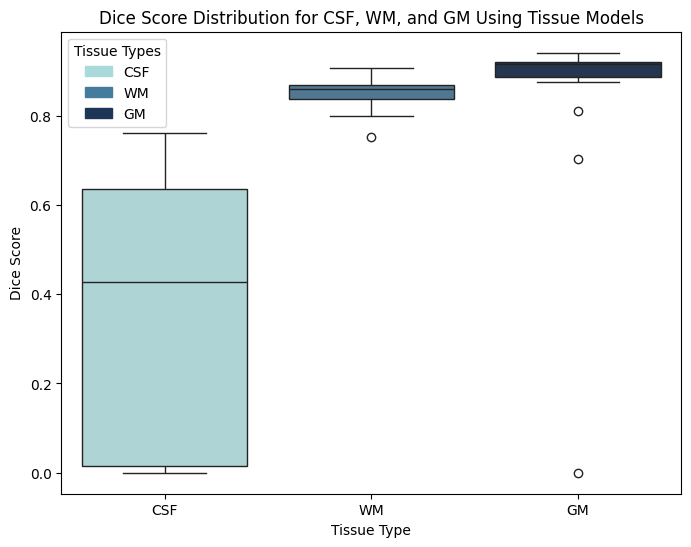

In [28]:
# Convert the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the Dice score boxplot
plot_dice_score_boxplot(metrics_df)

# Save the metrics DataFrame to a CSV file
metrics_df.to_csv('Result\\EM+LP\\em_lp_dice_scores.csv', index=False)